In [20]:
# Reproduce book environment
import random
random.seed(1234)

import logging
from pprint import pprint
from sys import stdout as STDOUT

## 項目 70 最適化の前にプロファイル

Pythonの動的な性質は、実行時の性能に関して驚くべき振る舞いを引き起こすことがあります。遅いはずだと想定した演算(文字列操作、ジェネレータなど)が実際には非常に速いことがあります。速いと想定した言語機能(属性アクセス、関数呼び出しなど) が実際には非常に遅いことがあります。Python プログラムで遅くなった真の原因を把握することは難しいのです。

最良の方策は、直観を無視して、プログラムを最適化する前に、その性能を直接測ることです。Python は、組み込みのプロファイラを提供していて、プログラムのどの部分が性能に責任あるかを決定できます。これによって、最適化の努力を問題が最も大きい部分に集中し、速度に影響がない部分を無視することができます (すなわち、アムダールの法則に従う)。

例えば、なぜ、このプログラムのアルゴリズムが遅いのかを突き止めたいとします。挿入ソートを使ってデータのリストをソートする関数を定義します。

In [21]:
# Example 1
def insertion_sort(data):
    result = []
    for value in data:
        insert_value(result, value)
    return result

挿入ソートでコアとなる機構はデータの各々について挿入点を見つける関数です。入力配列を線形
走査する、非常に効率の悪い関数 insert_value を次のように定義します。

In [22]:
# Example 2
def insert_value(array, value):
    for i, existing in enumerate(array):
        if existing > value:
            array.insert(i, value)
            return
    array.append(value)

insertion_sort と insert_value のプロファイルを取るために、乱数のデータを作り、プロファイラに渡す test 関数を定義します。

In [23]:
# Example 3
from random import randint

max_size = 10**4
data = [randint(0, max_size) for _ in range(max_size)]
test = lambda: insertion_sort(data)

Python は、2つの組み込みプロファイラを提供します。1つは、ピュア Python (profile) で、もう 1つはC拡張モジュール(cProfile) です。組み込みモジュール cProfile のほうが、プロファイル を取っているときに、プログラムの性能への影響が最小なので、適しています。ピュアPythonのだと オーバーヘッドが大きくて、 結果に歪みが出ます。

★ Python プログラムのプロファイルを取るとき、測定しているのがコードそのもので、 外部 システムではないことを確認すること。 ネットワークやディスク上の資源にアクセスする 関数に気をつけること。 それらは、その基盤システムそれ自体の遅さによって、 プログラ by ムの実行時間に大きな影響を及ぼす。 プログラムがそれらの遅い資源の遅延をカバーする ためにキャッシュを使っているなら、 プロファイルを取る前に、 十分にウォームアップして キャッシュの状態が大丈夫なことを確かめること。

cProfile モジュールから profile オブジェクトをインスタンス化して、runcall メソッドを使ってテスト関数を実行します。

In [24]:
# Example 4
from cProfile import Profile

profiler = Profile()
profiler.runcall(test)


[0,
 2,
 3,
 3,
 5,
 8,
 9,
 10,
 11,
 12,
 12,
 12,
 14,
 16,
 17,
 17,
 17,
 19,
 19,
 23,
 23,
 24,
 25,
 26,
 27,
 27,
 29,
 29,
 30,
 31,
 31,
 32,
 33,
 40,
 41,
 41,
 44,
 45,
 45,
 47,
 47,
 48,
 51,
 52,
 52,
 55,
 56,
 62,
 62,
 63,
 64,
 65,
 66,
 66,
 66,
 66,
 67,
 68,
 69,
 71,
 71,
 74,
 74,
 75,
 75,
 77,
 78,
 78,
 81,
 82,
 84,
 84,
 88,
 88,
 88,
 89,
 90,
 90,
 90,
 91,
 92,
 93,
 94,
 96,
 99,
 101,
 102,
 104,
 105,
 105,
 108,
 109,
 110,
 111,
 112,
 112,
 113,
 114,
 114,
 120,
 121,
 122,
 122,
 123,
 124,
 125,
 126,
 126,
 126,
 129,
 129,
 132,
 133,
 133,
 134,
 134,
 136,
 138,
 139,
 140,
 140,
 141,
 142,
 143,
 143,
 143,
 143,
 145,
 145,
 150,
 151,
 151,
 151,
 154,
 154,
 155,
 156,
 158,
 159,
 160,
 161,
 161,
 162,
 165,
 166,
 167,
 168,
 168,
 170,
 170,
 171,
 171,
 172,
 172,
 172,
 174,
 176,
 177,
 177,
 181,
 181,
 181,
 184,
 184,
 185,
 186,
 187,
 188,
 190,
 191,
 192,
 193,
 193,
 193,
 194,
 195,
 195,
 200,
 201,
 205,
 205,
 205,


テスト関数の実行が終わったら、組み込みモジュール pstatsとそのStatsクラスを使って性能に ついての統計情報を取り出せます。 Stats オブジェクトのさまざまなメソッドがプロファイル情報を どのように選択ソートして、必要なものだけを表示するように調整するのをサポートします。

In [25]:
# Example 5
from pstats import Stats

stats = Stats(profiler)
stats = Stats(profiler, stream=STDOUT)
stats.strip_dirs()
stats.sort_stats('cumulative')
stats.print_stats()


         20003 function calls in 0.950 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.950    0.950 757775735.py:6(<lambda>)
        1    0.003    0.003    0.950    0.950 587521532.py:2(insertion_sort)
    10000    0.941    0.000    0.948    0.000 3845090190.py:2(insert_value)
     9992    0.006    0.000    0.006    0.000 {method 'insert' of 'list' objects}
        8    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




この出力は、 関数ごとの情報の表です。 データサンプルは、プロファイラが先ほどのruncallメソッ
ドの中でアクティブになっている間だけ収集されたものです。


プロファイラの統計カラムの意味について簡単に解説します。
- ncalls
  - プロファイル期間に関数が呼ばれた回数。
- tottime
  - 他の関数呼び出しに費やした時間を除いた関数実行に費やした秒数。
- tottime percall
  - 他の関数呼び出しに費やした時間を除いた、関数が1回当たり呼び出されて実行に要した平均秒数。tottime をncallsで割ったもの。
- cumtime
  - それが呼び出している関数の実行に費やした時間も含めた関数実行に要した累積秒数。
- cumtime percall
  - 呼び出している関数の実行に費やした時間も含めた関数が1回当たりに呼び出されて実行に要した平均秒数。

上のプロファイラの統計表を見れば、テストでCPUの最大消費が insert_value 関数で費やした累積時間だとわかります。この関数をモジュール bisect を使って再定義します(「項目72 ソート済
みシーケンスの探索には bisect を考える」参照)。


In [26]:
# Example 6
from bisect import bisect_left

def insert_value(array, value):
    i = bisect_left(array, value)
    array.insert(i, value)

プロファイラを再度実行して新しいプロファイラ統計の表を生成します。新しい関数はずっと速く累積時間は修正前の insert_value 関数よりもほぼ100倍小さくなっています。


場合によると、全体のプログラムのプロファイルを取っているときに、実行時間の大半の責任を共通のユーティリティ関数が負っていることがわかります。 プロファイラのデフォルトの出力では、ユーティリティ関数がプログラムの多くの異なった部分からどのように呼ばれているかを示さないので、この状況の理解が難しいのです。

例えば、my_utility 関数がプログラム中の2つの異なる関数から繰り返し呼ばれている場合です。

In [27]:
# Example 8
def my_utility(a, b):
    c = 1
    for i in range(100):
        c += a * b

def first_func():
    for _ in range(1000):
        my_utility(4, 5)

def second_func():
    for _ in range(10):
        my_utility(1, 3)

def my_program():
    for _ in range(20):
        first_func()
        second_func()

このコードのプロファイルを取り、デフォルトのprint_stats出力を使って出力した統計はよくわかりません。

In [28]:
# Example 9
profiler = Profile()
profiler.runcall(my_program)
stats = Stats(profiler, stream=STDOUT)
stats.strip_dirs()
stats.sort_stats('cumulative')
stats.print_stats()

         20242 function calls in 0.073 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.073    0.073 3510307165.py:15(my_program)
       20    0.003    0.000    0.072    0.004 3510307165.py:7(first_func)
    20200    0.070    0.000    0.070    0.000 3510307165.py:2(my_utility)
       20    0.000    0.000    0.001    0.000 3510307165.py:11(second_func)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




my_utility 関数が明らかに実行時間の大半を占めますが、なぜこの関数がそれほど呼ばれているのかがすぐには明らかになりません。プログラムのコードを探せば、my_utility に複数の呼び出し元のあることがわかりますが、それでもまだはっきりしないでしょう。

こういうことを処理するために、Pythonプロファイラは、各関数のプロファイル情報に、どの呼び
出し元が貢献しているかを表示する方法を提供しています。

In [29]:
# Example 10
stats = Stats(profiler, stream=STDOUT)
stats.strip_dirs()
stats.sort_stats('cumulative')
stats.print_callers()

   Ordered by: cumulative time

Function                                          was called by...
                                                      ncalls  tottime  cumtime
3510307165.py:15(my_program)                      <- 
3510307165.py:7(first_func)                       <-      20    0.003    0.072  3510307165.py:15(my_program)
3510307165.py:2(my_utility)                       <-   20000    0.070    0.070  3510307165.py:7(first_func)
                                                         200    0.001    0.001  3510307165.py:11(second_func)
3510307165.py:11(second_func)                     <-      20    0.000    0.001  3510307165.py:15(my_program)
{method 'disable' of '_lsprof.Profiler' objects}  <- 




今度のプロファイラ統計表では、呼ばれた関数が左に、 呼び出しの責任を持つ側が右に示されます。 これで、my_utility が first_func でほとんど使われていることが明らかになります。

### 覚えておくこと

- 速度低下の原因がよくわかっていないことが多いので、最適化の前にPython プログラムのプロファイルを取ることが重要だ
- より正確なプロファイル情報が得られるので、profile モジュールではなく cProfileモジュールを使う
- Profile オブジェクトのruncallメソッドは、関数呼び出しの木を隔離してプロファイルを取るために必要なすべてを提供する
- Stats オブジェクトは、プログラムの性能を理解するために知る必要のあるプロファイル情報の部分集合を選び出して出力する

## 項目71 生産者消費者キューには deque のほうがよい

プログラムを書いているときに、生産者消費者キューとも呼ばれる、先入れ先出し (FIFO) キューが必要になることがある。FIFO キューは、ある関数が値を集め、それらの値を別の関数が受け取った順番に処理する場合に使われる。プログラマは、組み込み型の list を FIFO キューに使うことが多い。

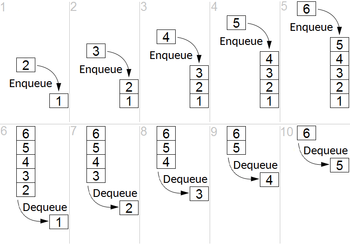
画像：[wikipedia](https://ja.wikipedia.org/wiki/FIFO)

例えば、受信したeメールを長期のアーカイブに保存するプログラムで、list を生産者消費者キューに使うとする。eメールのクラスを次のように定義する。

In [1]:
# Example 1
class Email:
    def __init__(self, sender, receiver, message):
        self.sender = sender
        self.receiver = receiver
        self.message = message

ソケット、ファイルシステム、または他の I/O (入出力) から1通だけeメールを受け取るプレースホルダ関数も定義する。実装上で、返り値は単にEmail インスタンスを返すか、メールが無い場合に NoEmail 例外を送出するかのいずれかとすれば良い。重要なのはそのインタフェースである。


In [2]:
# Example 2
def get_emails():
    yield Email('foo@example.com', 'bar@example.com', 'hello1')
    yield Email('baz@example.com', 'banana@example.com', 'hello2')
    yield None
    yield Email('meep@example.com', 'butter@example.com', 'hello3')
    yield Email('stuff@example.com', 'avocado@example.com', 'hello4')
    yield None
    yield Email('thingy@example.com', 'orange@example.com', 'hello5')
    yield Email('roger@example.com', 'bob@example.com', 'hello6')
    yield None
    yield Email('peanut@example.com', 'alice@example.com', 'hello7')
    yield None

EMAIL_IT = get_emails()

class NoEmailError(Exception):
    pass

def try_receive_email():
    # Returns an Email instance or raises NoEmailError
    try:
        email = next(EMAIL_IT)
    except StopIteration:
        email = None

    if not email:
        raise NoEmailError

    print(f'Produced email: {email.message}')
    return email

eメールを受け取ると、後で処理するためにキューに入れておく (エンキュー) 関数を生産者関数と呼ぶことにする。この関数は、list の append メソッドを使い、新しいメールメッセージをキューの末尾に追加するため、新しいメールは前のメッセージすべてが処理されてから処理されることになる。

In [3]:
# Example 3
def produce_emails(queue):
    while True:
        try:
            email = try_receive_email()
        except NoEmailError:
            return
        else:
            queue.append(email)  # Producer

キューに pop(0) 関数を呼び出し、list の先頭の要素を取り出す関数を消費者関数と呼ぶことにする。キューの先頭の要素から常に処理することにより、消費者関数は受け取った順番に処理する。


In [4]:
# Example 4
def consume_one_email(queue):
    if not queue:
        return
    email = queue.pop(0)  # Consumer
    # Index the message for long-term archival
    print(f'Consumed email: {email.message}')

最後にこれらの部品をつなげてループする関数が必要である。次の関数は、keep_running 関数が False を返すまで生産者と消費者を交互に呼び出す (これを並行に行う方法については「項目60 コルーチンで高度な並行 I/O を達成する」参照)。


In [5]:
# Example 5
def loop(queue, keep_running):
    while keep_running():
        produce_emails(queue)
        consume_one_email(queue)

def make_test_end():
    count=list(range(10))

    def func():
        if count:
            count.pop()
            return True
        return False

    return func


def my_end_func():
    pass

my_end_func = make_test_end()
loop([], my_end_func)

Produced email: hello1
Produced email: hello2
Consumed email: hello1
Produced email: hello3
Produced email: hello4
Consumed email: hello2
Produced email: hello5
Produced email: hello6
Consumed email: hello3
Produced email: hello7
Consumed email: hello4
Consumed email: hello5
Consumed email: hello6
Consumed email: hello7


try_receive_email (Example 2) で返される produce_emails の Email をなぜ処理しないのか。これはレイテンシー※とスループットの間のトレードオフがあるからである。
生産者消費者キューを使うとき、できるだけ早く要素を受け入れたいため、レイテンシーを最小化します。そうして、消費者はバックログを一定のペースで (この場合はループするごとに)、処理できる。これは、安定した能率と一貫したスループットを達成するが、最終的なレイテンシーに課題が残る (関連ベストプラクティスは「項目55 スレッド間の協調作業には Queue を使う」参照)。

※
- レイテンシー：ユーザーのアクションとその後の応答の間に経過する時間（[参考](https://jp.vcube.com/sdk/blog/what-is-latency#section1)）
- スループット：コンピュータやネットワーク機器が単位時間あたりに処理できるデータ量。あるいは、その数値を使ってデータ処理能力やデータ転送速度。（[参考](https://it-trend.jp/words/throughput)）

このように list を生産者消費者キューに使うのはある程度までは大丈夫である。しかし、リストの要素の個数、すなわちカーディナリティが増大すると、list 型の性能は超線形的に低下してしまう。list を FIFO キューに使った場合の性能分析のため、組み込みモジュール timeit を使ったミクロベンチマークを実行してみる。list の append メソッドを使い、要素をキューに追加する性能評価のベンチマークを次のように定義する。


In [6]:
# Example 6
import timeit

def print_results(count, tests):
    avg_iteration = sum(tests) / len(tests)
    print(f'Count {count:>5,} takes {avg_iteration:.6f}s')
    return count, avg_iteration

def list_append_benchmark(count):
    def run(queue):
        for i in range(count):
            queue.append(i)

    tests = timeit.repeat(
        setup='queue = []',
        stmt='run(queue)',
        globals=locals(),
        repeat=1000,
        number=1)

    return print_results(count, tests)

このベンチマーク関数をさまざまなカーディナリティで実行することで、データサイズに関する性能比較ができる。

In [8]:
# Example 7
def print_delta(before, after):
    before_count, before_time = before
    after_count, after_time = after
    growth = 1 + (after_count - before_count) / before_count
    slowdown = 1 + (after_time - before_time) / before_time
    print(f'{growth:>4.1f}x data size, {slowdown:>4.1f}x time')

baseline = list_append_benchmark(500)
for count in (1_000, 2_000, 3_000, 4_000, 5_000):
    print()
    comparison = list_append_benchmark(count)
    print_delta(baseline, comparison)

Count   500 takes 0.000019s

Count 1,000 takes 0.000037s
 2.0x data size,  2.0x time

Count 2,000 takes 0.000077s
 4.0x data size,  4.1x time

Count 3,000 takes 0.000107s
 6.0x data size,  5.7x time

Count 4,000 takes 0.000140s
 8.0x data size,  7.5x time

Count 5,000 takes 0.000175s
10.0x data size,  9.4x time


この結果は、append メソッドが list 型でほぼ定数時間かかり、エンキューがデータサイズの増加に線形にスケールすることを示している。新たな要素の追加に伴うオーバーヘッドが list 型にはあるが、それは比較的小さく、append を繰り返し呼び出す中に隠されている。

同様のベンチマークをキューの先頭から要素を取り出す pop(0) 呼び出し (消費者関数に対応) について定義する。


In [9]:
# Example 8
def list_pop_benchmark(count):
    def prepare():
        return list(range(count))

    def run(queue):
        while queue:
            queue.pop(0)

    tests = timeit.repeat(
        setup='queue = prepare()',
        stmt='run(queue)',
        globals=locals(),
        repeat=1000,
        number=1)

    return print_results(count, tests)

このベンチマークをさまざまなサイズのキューで実行し、カーディナリティが性能にどう影響するかを調べる。


In [10]:
# Example 9
baseline = list_pop_benchmark(500)
for count in (1_000, 2_000, 3_000, 4_000, 5_000):
    print()
    comparison = list_pop_benchmark(count)
    print_delta(baseline, comparison)

Count   500 takes 0.000228s

Count 1,000 takes 0.000891s
 2.0x data size,  3.9x time

Count 2,000 takes 0.003563s
 4.0x data size, 15.6x time

Count 3,000 takes 0.008025s
 6.0x data size, 35.2x time

Count 4,000 takes 0.010679s
 8.0x data size, 46.9x time

Count 5,000 takes 0.021002s
10.0x data size, 92.2x time


驚くべきことに、pop(0) による list からの要素取り出し (デキュー) の全時間はキューの長さの二乗で増加する。原因は、pop(0) が list の全要素を1つずつ前に戻し、要素全体を再代入することになっているからである。list の全要素を pop(0) する必要があるため、結局ほぼ len(queue) * len(queue) 個の演算がキューに必要となる。これではスケールしない。

Python には、この問題を解決する組み込みモジュール collections の deque クラスがある。deque は両端キューの実装である。要素を先頭または末尾に追加または削除するとき、定時間演算を行うため、FIFO キューの実装に理想的なものである。

deque クラスを使うと、produce_emails の append 呼び出しは list を使っていたときと同じでよく、consume_one_email の list.pop メソッド呼び出しは、引数なしの deque.popleft メソッド呼び出しに変えることとなる。また、loop メソッドは、list ではなく deque インスタンスで呼ぶよう変更する必要があるが、他の実装部分は変えなくてよい。新たなメソッドを使い loop を実行する関数を定義する。


In [11]:
# Example 10
import collections

def consume_one_email(queue):
    if not queue:
        return
    email = queue.popleft()  # Consumer
    # Process the email message
    print(f'Consumed email: {email.message}')

def my_end_func():
    pass

my_end_func = make_test_end()
EMAIL_IT = get_emails()
loop(collections.deque(), my_end_func)

Produced email: hello1
Produced email: hello2
Consumed email: hello1
Produced email: hello3
Produced email: hello4
Consumed email: hello2
Produced email: hello5
Produced email: hello6
Consumed email: hello3
Produced email: hello7
Consumed email: hello4
Consumed email: hello5
Consumed email: hello6
Consumed email: hello7


(生産者関数に対応した) append 性能が (定数因子を除いて) ほぼ同じであることを検証するベンチマークを実行する。

In [12]:
# Example 11
def deque_append_benchmark(count):
    def prepare():
        return collections.deque()

    def run(queue):
        for i in range(count):
            queue.append(i)

    tests = timeit.repeat(
        setup='queue = prepare()',
        stmt='run(queue)',
        globals=locals(),
        repeat=1000,
        number=1)
    return print_results(count, tests)

baseline = deque_append_benchmark(500)
for count in (1_000, 2_000, 3_000, 4_000, 5_000):
    print()
    comparison = deque_append_benchmark(count)
    print_delta(baseline, comparison)

Count   500 takes 0.000016s

Count 1,000 takes 0.000033s
 2.0x data size,  2.0x time

Count 2,000 takes 0.000068s
 4.0x data size,  4.2x time

Count 3,000 takes 0.000103s
 6.0x data size,  6.4x time

Count 4,000 takes 0.000138s
 8.0x data size,  8.6x time

Count 5,000 takes 0.000174s
10.0x data size, 10.8x time


消費者関数での deque 使用に対応する popleft 呼び出しのベンチマークも実行する。


In [13]:
# Example 12
def dequeue_popleft_benchmark(count):
    def prepare():
        return collections.deque(range(count))

    def run(queue):
        while queue:
            queue.popleft()

    tests = timeit.repeat(
        setup='queue = prepare()',
        stmt='run(queue)',
        globals=locals(),
        repeat=1000,
        number=1)

    return print_results(count, tests)

baseline = dequeue_popleft_benchmark(500)
for count in (1_000, 2_000, 3_000, 4_000, 5_000):
    print()
    comparison = dequeue_popleft_benchmark(count)
    print_delta(baseline, comparison)


Count   500 takes 0.000015s

Count 1,000 takes 0.000031s
 2.0x data size,  2.1x time

Count 2,000 takes 0.000062s
 4.0x data size,  4.0x time

Count 3,000 takes 0.000093s
 6.0x data size,  6.1x time

Count 4,000 takes 0.000126s
 8.0x data size,  8.3x time

Count 5,000 takes 0.000157s
10.0x data size, 10.3x time


popleft の使用は、以前測ったpop(0) の超線形な振る舞いではなく、線形にスケールしている。このように、プログラムの性能が生産者消費者キューの速度に依存しているのであれば、deque を選択すべきである。もし、性能が不明であれば、プログラムの性能を測るべきである (「項目70 最適化の前にプロファイル」参照)。

### 覚えておくこと

- 生産者が append 呼び出しで要素を追加し、消費者がpop(0) 呼び出しで要素を受け取ることで、list 型を FIFO に使える。しかし、これは pop(0) がキューの長さで超線形性能低下を招くので問題となる。
- 組み込みモジュール collections の deque クラスは、キューの長さにかかわらず append と popleft が定数時間なので、FIFO キューに理想的だ。


## 項目72 ソート済みシーケンスの探索には bisect を考える

メモリ内のソート済みリストの大量のデータで探索したいというニーズは良くあるだろう。例えば、スペルチェックのために英語辞書を使うとか、日付の入った取引記録の list で監査を行う場合等が考えられる。

プログラムで処理するデータが何であれ、list で特定の値を探索するには、index メソッドを呼び出したリストの長さに比例する線形時間がかかってしまう。


In [14]:
# Example 1
data = list(range(10**5))
index = data.index(91234)
assert index == 91234

探索する値が list にあるかどうかが不明な場合に、その値に等しいか、あるいはそれより大きい値で最も近いインデックスを探すとする。これを行う最も簡単な方法は、list を線形走査して、各要素を目標値と比較することである。


In [15]:
# Example 2
def find_closest(sequence, goal):
    for index, value in enumerate(sequence):
        if goal < value:
            return index
    raise ValueError(f'{goal} is out of bounds')

index = find_closest(data, 91234.56)
assert index == 91235

try:
    find_closest(data, 100000000)
except ValueError:
    pass  # Expected
else:
    assert False

Python の組み込みモジュール bisect は、 この種の整列したリストの探索により良い方法を提供している。bisect_left 関数を使い、ソートされた要素のシーケンスに対して、効率的な二分探索ができる。返すインデックスは、要素が存在する list の位置か、要素を挿入しても整列が保たれる list の位置である。

In [16]:
# Example 3
from bisect import bisect_left

index = bisect_left(data, 91234)     # Exact match
assert index == 91234

index = bisect_left(data, 91234.56)  # Closest match
assert index == 91235

bisect モジュールの二分探索アルゴリズムの計算量は対数時間 log(n) である。つまり、100万個の要素を持つリストを bisect で探すのは、長さ20のリストを list.index メソッドの線形探索とほぼ同じ時間 (math.log2(10**6) == 19.93...) ということであり、線形のアルゴリズムよりもずっと速い。

timeit を使ったミクロベンチマークを実行して、速度向上を検証してみる。


In [ ]:
# Example 4
import random
import timeit

size = 10**5
iterations = 1000

data = list(range(size))
to_lookup = [random.randint(0, size)
             for _ in range(iterations)]

def run_linear(data, to_lookup):
    for index in to_lookup:
        data.index(index)

def run_bisect(data, to_lookup):
    for index in to_lookup:
        bisect_left(data, index)

baseline = timeit.timeit(
    stmt='run_linear(data, to_lookup)',
    globals=globals(),
    number=10)
print(f'Linear search takes {baseline:.6f}s')

comparison = timeit.timeit(
    stmt='run_bisect(data, to_lookup)',
    globals=globals(),
    number=10)
print(f'Bisect search takes {comparison:.6f}s')

slowdown = 1 + ((baseline - comparison) / comparison)
print(f'{slowdown:.1f}x time')


bisect の最も良いところは、list 型に限らないことである。シーケンス (比較可能なオブジェクト) として振る舞うどのような Python オブジェクトにも使うことができる (やり方は「項目43 カスタムコンテナ型は collections.abc を継承する」参照)。モジュールには、より高度な状況のための追加機能もある (help (bisect) 参照) 。

### 覚えておくこと

- ソート済みリストの探索で、index メソッドや for ループの単純比較は線形時間かかる。
- 組み込みモジュール bisect の bisect_left 関数は、ソート済みリストの探索を対数時間で行い、他の方式より桁違いに速い。
